# Hintergrund der Datenanalyse

Die Aargauer Regierung und die bürgerlichen Parteien wollen den Spitzen-Gewinnsteuersatz für Firmen im Kanton Aargau von 18,6 auf 15,1 Prozent senken, um für Firmen attraktiv zu bleiben.

# These

Die Firmensteuern sind im Kanton Aargau in den vergangenen zwei Jahrzehnten stärker gesunken als die Steuern für natürliche Personen. Dies, weil der Steuerwettbewerb um Firmen national und international spielt. Dadurch sind die Steuererträge der Einwohner für den Kanton wichtiger geworden im Vergleich zu jenen der Firmen.

# Code ESTV_1 - Vorbereitung

Da es sich bei den auszuwertenden Dateien um Excel-Dateien von Behörden handelt, müssen die Daten nach dem Einlesen zunächst in Form gebracht werden: Unnötige Zeilen und Spalten sind zu löschen, Spalten neu zu beschriften etc.

Die Daten kommen aus zwei verschiedenen Dateien, deren Struktur fast identisch ist. Deshalb wird eine Funktion gebildet (einheit), die den Dokumentennamen und den Namen eines Tabellenblattes entgegennimmt und die Daten dieses Blattes in eine Form bringt. Dank der gleichen Form können die Daten später gemergt werden.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#Auflistung der Dateinamen und der relevanten Tabellenblätter
daten_jur = 'Daten/estv_steuerbelastung04-16_juristisch.xlsx'
sheet_name_jur = 'Ordentlich'

daten_nat = 'Daten/estv_steuerbelastung04-16_natürlich.xlsx'
sheet_names_nat = ['Lediger', 'Verheiratet ohne Kinder', 'Verheiratet mit Kindern', 'Rentnerpaar']

# Code ESTV_1 - Funktion zur Vereinheitlichung der Daten nat./jur.

Für die juristischen Personen wird nur das erste Tabellenblatt benötigt, für die natürlichen mehrere. Deshalb muss die Funktion zweimal angewendet werden. Für die natürlichen Personen wird jedes Tabellenblatt einzeln in einem Loop durch die Funktion gejagt und das Ergebnis durch pd.concat zu einem Dataframe zusammengefügt.

Am Schluss resultieren zwei Dataframes: df_jur und df_nat mit folgenden Spalten:

1. Index (Jahr)
2. Einkommen/Gewinn (3 Gewinntypen bei jur., 5 Einkommensstufen bei nat.)
3. average_steuerbelastung_%
4. Geo (AG oder CH)
5. Status (Haushaltstyp)

In [3]:
def einheit(dokument, tabellenblatt):
    #Einlesen von Datei und Tabellenblatt
    df = pd.read_excel(dokument, sheet_name=tabellenblatt, skiprows=4)
    
    #Kantonsangabe in der Kantonsspalte durchgängig ergänzen
    df['Kanton'] = df['Kanton'].ffill()
    
    #Die zweite Spalte umbenennen, damit sie einheitlich benannt ist (sie heisst nicht immer gleich in den Tabellenblättern)
    df.rename(columns={df.columns[1]: 'Einkommen/Gewinn'}, inplace=True)
    
    #Die Angabe in dieser Spalte durchgängig ergänzen
    df['Einkommen/Gewinn'] = df['Einkommen/Gewinn'].ffill()
    
    #Nur die Zeilen behalten, die die Steuerbelastung in Prozent enthalten
    df = df[df['Unnamed: 2'] == '[%]'].copy()
    
    #unnötige Spalte löschen
    del df['Unnamed: 2']
    
    #Einkommen/Gewinn als Index
    df.set_index('Einkommen/Gewinn', inplace=True)
    
    #neues df_ch. Durch groupby den CH-Durchschnitt pro Einkommen/Gewinntyp und Jahr generieren
    df_ch = df.groupby(df.index).mean()
    
    #durch pd.melt vom Wide- zum Long-Format mit den Jahreszahlen in einer Spalte.
    #Wichtig: Einkommen/Gewinn als Index behalten (ignore_index=False)
    df_ch = pd.melt(df_ch, var_name='Jahr', value_name='average_steuerbelastung_%', ignore_index=False)
    
    #Geo-Information ('CH') als Spalte hinzufügen
    df_ch['Geo'] = 'CH'
    
    #Jahresangaben als einzigen Index setzen
    df_ch.reset_index(inplace=True)
    df_ch.set_index('Jahr', inplace=True)
    
    #Nun dasselbe für den Aargau. Neues df_ag, bestehend aus allen Einträgen wo df['Kanton'] == 'AG'
    df_ag = df[df['Kanton'] == 'AG'].copy()
   
    #Vorbereitung für pd.melt: Kantonsspalte löschen (wird nach pd.melt durch 'Geo' ersetzt)
    del df_ag['Kanton']
    
    #durch pd.melt vom Wide- zum Long-Format mit den Jahreszahlen in einer Spalte.
    #Wichtig: Einkommen/Gewinn als Index behalten (ignore_index=False)
    df_ag = pd.melt(df_ag, var_name='Jahr', value_name='average_steuerbelastung_%', ignore_index=False)
    
    #Geo-Information ('AG') hinzufügen
    df_ag['Geo'] = 'AG'
    
    #Jahr als einzigen Index setzen
    df_ag.reset_index(inplace=True)
    df_ag.set_index('Jahr', inplace=True)
    
    #CH- und AG-Werte durch pd.concat in einem df zusammenführen
    df_final = pd.concat([df_ch, df_ag])
    
    #Den Daten den entsprechenden Haushaltstyp resp. Firmenstatus mitgeben
    df_final['Status'] = tabellenblatt
    
    return df_final

In [4]:
#Anwenden der Funktion auf die juristischen Daten, nur ein Tabellenblatt (0rdentlich)
df_jur = einheit(daten_jur, sheet_name_jur)

In [5]:
df_jur.head()

,Einkommen/Gewinn,average_steuerbelastung_%,Geo,Status
Jahr,,,,
2004,1.0,17.831045,CH,Ordentlich
2004,2.0,15.264804,CH,Ordentlich
2004,3.0,15.095598,CH,Ordentlich
2005,1.0,17.939583,CH,Ordentlich
2005,2.0,15.345981,CH,Ordentlich


In [6]:
df_jur.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 2004 to 2016
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Einkommen/Gewinn           78 non-null     float64
 1   average_steuerbelastung_%  78 non-null     float64
 2   Geo                        78 non-null     object 
 3   Status                     78 non-null     object 
dtypes: float64(2), object(2)
memory usage: 3.0+ KB


In [7]:
#Anwenden der Funktion auf die natürlichen Daten. Mehrere Tabellenblätter, darum Loop
#Zusammenführen der Daten aller Tabellenblätter mit pd.concat in df_nat
df_nat = pd.DataFrame([])

for name in sheet_names_nat:
    df_temp = einheit(daten_nat, name)
    df_nat = pd.concat([df_nat, df_temp])
    
#Werte bei den Rentnern vor 2008 nullen, wegen Methodenänderung
df_nat.loc[(df_nat['Status'] == 'Rentnerpaar') & (df_nat.index < 2008), 'average_steuerbelastung_%'] = np.nan

In [8]:
df_nat.head()

,Einkommen/Gewinn,average_steuerbelastung_%,Geo,Status
Jahr,,,,
2004,50000.0,9.787593,CH,Lediger
2004,100000.0,14.684892,CH,Lediger
2004,200000.0,18.564800,CH,Lediger
2004,500000.0,21.294482,CH,Lediger
2004,1000000.0,22.039582,CH,Lediger


In [9]:
df_nat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 2004 to 2016
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Einkommen/Gewinn           520 non-null    float64
 1   average_steuerbelastung_%  480 non-null    float64
 2   Geo                        520 non-null    object 
 3   Status                     520 non-null    object 
dtypes: float64(2), object(2)
memory usage: 20.3+ KB


# Code ESTV_1 - 1. Teilauswertung

In einer zweiten Funktion (vor_merge) werden die Daten zunächst so hergerichtet, dass sie danach anhand des Index ('Jahr') gemergt werden können. Ziel ist es, die Daten so zusammenzustellen, dass sie vom Visualisierungsdienst Q-Tool (Entwicklung der NZZ, die auch CH Media nutzt) visualisiert werden können für die 1. Auswertung:

1. Steuerbelastung 2004-2016 ordentlich besteuerte Firmen vs. natürliche Personen (Aargau und CH-Durchschnitt)

In [10]:
def vor_merge(df, person):
    #Groupby auf eingespiesenes df nach Index ('Jahr') und Geo (AG und CH).
    #Berechnet wird der Durchschnitt der Steuerbelastung nach Jahr und Geo-Region
    df_vor_merge = pd.DataFrame(df.groupby([df.index, 'Geo'])['average_steuerbelastung_%'].mean())
    
    #Jahr als einziger Index
    df_vor_merge.reset_index(inplace=True)
    df_vor_merge.set_index('Jahr', inplace=True)
    
    #Pivot long to wide, damit die Geo-Region in den Spaltennamen kommt (für die Visualisierung nötig)
    df_vor_merge = df_vor_merge.pivot_table(index=df_vor_merge.index, columns='Geo', values='average_steuerbelastung_%')
    
    #den Geo-Regionen in den Spaltentiteln ein Suffix ('_jur' oder '_nat') hinzufügen, damit nach dem Merge die Unterscheidung möglich ist
    df_vor_merge = df_vor_merge.add_suffix(f'_{person}')
    
    return df_vor_merge

Die beiden Dataframes df_jur und df_nat werden in einen Dictionary verpackt, durch den anschliessend iteriert wird. Im Loop wird die Funktion vor_merge aufgerufen und mit einem Dataframe gefüttert. Der Output wird in einer Liste gespeichert. Anschliessend können die zwei Inhalte der Liste gemergt werden.

In [11]:
df_dict = {'jur': df_jur, 'nat': df_nat}

df_liste = []

for key, value in df_dict.items():
    df_temp = vor_merge(value, key)
    df_liste.append(df_temp)
    
df_steuerbelastung = df_liste[0].merge(df_liste[1], left_index=True, right_index=True)

#Export für Q-Tool
df_steuerbelastung.to_csv('Ergebnisse/steuerbelastung_nat_jur_ag_ch.csv')

In [12]:
df_steuerbelastung.head()

Geo,AG_jur,CH_jur,AG_nat,CH_nat
Jahr,,,,
2004,17.897042,16.063816,15.233130,15.144040
2005,17.897042,16.044794,15.171329,14.969024
2006,17.897042,15.407893,15.097528,14.738526
2007,15.052917,14.777301,15.074482,14.588964
2008,14.699833,13.681668,15.169104,14.616555


In [13]:
df_steuerbelastung.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 2004 to 2016
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AG_jur  13 non-null     float64
 1   CH_jur  13 non-null     float64
 2   AG_nat  13 non-null     float64
 3   CH_nat  13 non-null     float64
dtypes: float64(4)
memory usage: 1.1 KB


**Zwischenfazit** Gemäss untenstehender Darstellung ist die Steuerbelastung für Firmen zwischen 2004 und 2016 im Aargau und im Durchschnitt der Kantone stärker gesunken als für natürliche Personen.

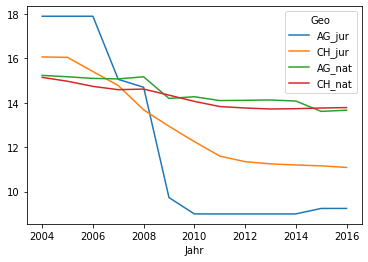

In [14]:
df_steuerbelastung.plot()

# Code ESTV_1 - 2. Teilauswertung

Die zweite Auswertung ist in zwei Teile unterteilt:

2. Steuerbelastung für einzelne Haushaltstypen (Ledig, verheiratet mit/ohne Kinder, Rentnerpaar)
    1. Veränderung pro Jahr und Haushaltstyp -> df_status (Basis für Linien-Grafik)
    2. Veränderung pro Haushaltstyp im Aargau von 2004 zu 2016 in Prozent -> df_status2 (Basis für Tabelle)
    
Benötigt wird zur Berechnung das df_nat.

In [15]:
#df_nat wird gruppiert, sodass die durchschn. Steuerbelastung pro Jahr (index), Geo-Region und Haushaltstyp (Status) vorliegt.
df_status = pd.DataFrame(df_nat.groupby([df_nat.index, 'Geo', 'Status'])['average_steuerbelastung_%'].mean())

#Jahr als einziger Index
df_status.reset_index(inplace=True)
df_status.set_index('Jahr', inplace=True)

#Pivot von long to wide, damit die Geo-Region in die Spaltentitel kommt. Dies als Vorbereitung für die Visualisierung
df_status = df_status.pivot_table(index=df_status.index, columns=['Geo', 'Status'], values='average_steuerbelastung_%')

#Nun hat das Dataframe zwei Spaltentitel-Ebenen. Um sie zusammenzuführen,
#wird ein Join-Vorgang in einer List comprehension angewendet (für jeden Spaltentitel:
#füge beide Titel mit einem Bodenstrich dazwischen zusammen)
df_status.columns = ['_'.join(col) for col in df_status.columns]

#Export für Q-Tool
df_status.to_csv('Ergebnisse/steuerbelastung_nat_haushaltstyp.csv')

In [16]:
df_status.head()

,AG_Lediger,AG_Rentnerpaar,AG_Verheiratet mit Kindern,AG_Verheiratet ohne Kinder,CH_Lediger,CH_Rentnerpaar,CH_Verheiratet mit Kindern,CH_Verheiratet ohne Kinder
Jahr,,,,,,,,
2004,18.210044,NaN,12.994708,14.494640,17.274270,NaN,13.322189,14.835660
2005,18.136165,NaN,12.941987,14.435834,17.152627,NaN,13.100338,14.654107
2006,18.047942,NaN,12.879031,14.365612,16.947531,NaN,12.847969,14.420079
2007,18.020391,NaN,12.859371,14.343682,16.850734,NaN,12.654158,14.262000
2008,17.533351,16.675231,12.511819,13.956013,16.375845,16.210755,12.120376,13.759245


In [17]:
df_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 2004 to 2016
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AG_Lediger                  13 non-null     float64
 1   AG_Rentnerpaar              9 non-null      float64
 2   AG_Verheiratet mit Kindern  13 non-null     float64
 3   AG_Verheiratet ohne Kinder  13 non-null     float64
 4   CH_Lediger                  13 non-null     float64
 5   CH_Rentnerpaar              9 non-null      float64
 6   CH_Verheiratet mit Kindern  13 non-null     float64
 7   CH_Verheiratet ohne Kinder  13 non-null     float64
dtypes: float64(8)
memory usage: 936.0 bytes


Nun wird für jeden Haushaltstyp mit jedem Einkommen für den Aargau errechnet, wie stark sich die Steuerbelastung seit 2004 verändert hat (in Prozent). Dazu wird ein Loop gebaut, der durch die Tabellenblätter iteriert und ein innerer Loop, der durch eine Liste der Einkommen iteriert.

In [18]:
#Erstellen der Liste mit den Einkommen
einkommen_liste = df_nat['Einkommen/Gewinn'].unique().tolist()

for name in sheet_names_nat:
    
    #Leeres Dataframe, das durch den inneren Loop gefüllt wird mit den Belastungen pro Jahr (wide-Format für Visualisierung)...
    #... und der Veränderung von 2016 ggü. 2004
    df_status2 = pd.DataFrame([])
    
    for einkommen in einkommen_liste:
            #Anhand der Variablen das df zusammenstellen
            df = df_nat[(df_nat['Status'] == name) & (df_nat['Einkommen/Gewinn'] == einkommen) & (df_nat['Geo'] == 'AG')].copy()
            
            #Zwei Spalten löschen, eine umbenennen
            df = df.drop(columns=['Geo', 'Status'])
            df.rename(columns={'Einkommen/Gewinn': 'Brutto-Einkommen'}, inplace=True)
            
            #Pivot long to wide, sodass jede Spalte ein Jahr darstellt (für die Visualisierung)
            df = df.pivot_table(index='Brutto-Einkommen', columns=df.index, values='average_steuerbelastung_%')
            
            #neue Spalte: Veränderung 2016 ggü. 2004 resp. 2008 (Rentner) in Prozent
            if name == 'Rentnerpaar':
                df['Veränderung seit 2008'] = (((df[2016]-df[2008]) / df[2008]) * 100).round(1)
            else:
                df['Veränderung seit 2004'] = (((df[2016]-df[2004]) / df[2004]) * 100).round(1)
            
            #Das Dataframe wird durch pd.concat dem df_status2 hinzugefügt
            df_status2 = pd.concat([df_status2, df])
    
    #Sobald alle Einkommens-Niveaus pro Haushaltstyp im df_status2 sind, erfolgt der Export für Datawrapper...
    #... mit entsprechender Benennung nach Haushaltstyp ('name')
    #jeder Haushaltstyp wird bewusst in einem eigenen df exportiert, weil für jeden eine eigene Tabelle gebildet wird,
    #die dann miteinander verlinkt werden: https://www.datawrapper.de/_/OBuic/
    df_status2.to_csv(f'Ergebnisse/Auswertung_2b/status_{name}.csv')